<a href="https://colab.research.google.com/github/mimilazarova/DD2424-covid-xray-project/blob/master/playground_colab_mimi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle
from sklearn.metrics import confusion_matrix, classification_report


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#**Load data set**

In [0]:

with open('/content/drive/My Drive/Colab Notebooks/data/trainX1.pickle', 'rb') as f:
  X1 = pickle.load(f)
with open('/content/drive/My Drive/Colab Notebooks/data/trainX2.pickle', 'rb') as f:
  X2 = pickle.load(f)

train_X = np.concatenate((X1, X2))

with open('/content/drive/My Drive/Colab Notebooks/data/testX.pickle', 'rb') as f:
  test_X = pickle.load(f)
with open('/content/drive/My Drive/Colab Notebooks/data/train_y.pickle', 'rb') as f:
  train_y = pickle.load(f)
with open('/content/drive/My Drive/Colab Notebooks/data/test_y.pickle', 'rb') as f:
  test_y = pickle.load(f)



Get class weights

In [0]:
class_weights = {}
for c in range(3):
  class_weights[c] = 1000/np.sum(train_y==c)
  print(class_weights[c])


0.12553351744915892
0.183452577508714
4.484304932735426


In [0]:
train_N = train_X.shape[0]
test_N = test_X.shape[0]

train_X = train_X.reshape((train_N, 224, 224, 1))
test_X = test_X.reshape((test_N, 224, 224, 1))

print("train_y bincount: ", np.bincount(train_y))
print("test_y bincount: ", np.bincount(test_y))

train_y bincount:  [7966 5451  223]
test_y bincount:  [885 594  31]


In [0]:
#plotting learning curve
def plot_history(history):
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0.5, 1])
  plt.legend(loc='lower right')

# **Model 1**
1. Model definition

In [0]:
model1 = keras.models.Sequential()
model1.add(layers.Conv2D(64, (3, 3), padding = 'same', activation='relu', input_shape=(224, 224, 1)))
model1.add(layers.MaxPooling2D((4, 4)))
model1.add(layers.Conv2D(64, (3, 3), padding = 'same', activation='relu'))
model1.add(layers.MaxPooling2D((4, 4)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.Flatten())
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dense(32, activation='relu'))
model1.add(layers.Dense(3))

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                5

2. Training

In [0]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

history1 = model1.fit(train_X, train_y, epochs=25, 
                    validation_data=(test_X, test_y))


Epoch 1/25
427/427 [==============================] - 11s 25ms/step - loss: 0.5005 - accuracy: 0.8024 - val_loss: 0.4033 - val_accuracy: 0.8457
Epoch 2/25
427/427 [==============================] - 10s 24ms/step - loss: 0.4099 - accuracy: 0.8454 - val_loss: 0.3988 - val_accuracy: 0.8404
Epoch 3/25
427/427 [==============================] - 10s 24ms/step - loss: 0.3724 - accuracy: 0.8578 - val_loss: 0.3302 - val_accuracy: 0.8788
Epoch 4/25
427/427 [==============================] - 10s 24ms/step - loss: 0.3406 - accuracy: 0.8720 - val_loss: 0.3279 - val_accuracy: 0.8748
Epoch 5/25
427/427 [==============================] - 10s 24ms/step - loss: 0.3106 - accuracy: 0.8830 - val_loss: 0.3002 - val_accuracy: 0.8795
Epoch 6/25
427/427 [==============================] - 10s 24ms/step - loss: 0.2889 - accuracy: 0.8933 - val_loss: 0.2907 - val_accuracy: 0.8967
Epoch 7/25
427/427 [==============================] - 10s 24ms/step - loss: 0.2672 - accuracy: 0.9015 - val_loss: 0.2713 - val_accuracy:

3. Performance

Confusion matrix:
[[808  77   0]
 [ 89 503   2]
 [  8  12  11]]
              precision    recall  f1-score   support

           0      0.893     0.913     0.903       885
           1      0.850     0.847     0.848       594
           2      0.846     0.355     0.500        31

    accuracy                          0.875      1510
   macro avg      0.863     0.705     0.750      1510
weighted avg      0.875     0.875     0.873      1510



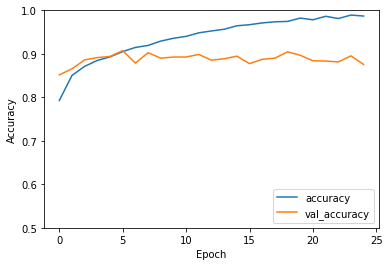

In [0]:
plot_history(history1)

# predictions
pred = model1.predict(test_X)
pred_1 = np.argmax(pred, axis=1) # one-hot encoding

conf_matrix = confusion_matrix(test_y, pred_1, labels=[0, 1, 2])
print("Confusion matrix:")
print(conf_matrix)
print(classification_report(test_y, pred_1, digits=3))

# **Model 2**
1. Model Definition

In [0]:
model2 = keras.models.Sequential()
model2.add(layers.Conv2D(64, (3, 3), padding = 'same', activation='relu', input_shape=(224, 224, 1)))
model2.add(layers.MaxPooling2D((4, 4)))
model2.add(layers.Conv2D(128, (3, 3), padding = 'same', activation='relu'))
model2.add(layers.MaxPooling2D((4, 4)))
model2.add(layers.Conv2D(256, (3, 3), activation='relu'))
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(32, activation='relu'))
model2.add(layers.Dense(3))

model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 256)       295168    
_________________________________________________________________
flatten (Flatten)            (None, 36864)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                2

2. Training

In [0]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

history2 = model2.fit(train_X, train_y, epochs=25, 
                    validation_data=(test_X, test_y))


Epoch 1/25
427/427 [==============================] - 37s 88ms/step - loss: 0.4926 - accuracy: 0.8000 - val_loss: 0.3882 - val_accuracy: 0.8483
Epoch 2/25
427/427 [==============================] - 37s 86ms/step - loss: 0.3926 - accuracy: 0.8529 - val_loss: 0.4230 - val_accuracy: 0.8391
Epoch 3/25
427/427 [==============================] - 37s 86ms/step - loss: 0.3499 - accuracy: 0.8647 - val_loss: 0.3311 - val_accuracy: 0.8748
Epoch 4/25
427/427 [==============================] - 37s 86ms/step - loss: 0.3075 - accuracy: 0.8845 - val_loss: 0.3290 - val_accuracy: 0.8755
Epoch 5/25
427/427 [==============================] - 37s 86ms/step - loss: 0.2785 - accuracy: 0.8951 - val_loss: 0.2750 - val_accuracy: 0.9007
Epoch 6/25
427/427 [==============================] - 37s 86ms/step - loss: 0.2461 - accuracy: 0.9082 - val_loss: 0.2768 - val_accuracy: 0.9053
Epoch 7/25
427/427 [==============================] - 37s 86ms/step - loss: 0.2247 - accuracy: 0.9160 - val_loss: 0.2957 - val_accuracy:

3. Performance

Confusion matrix:
[[812  72   1]
 [ 73 518   3]
 [  6   7  18]]
              precision    recall  f1-score   support

           0      0.911     0.918     0.914       885
           1      0.868     0.872     0.870       594
           2      0.818     0.581     0.679        31

    accuracy                          0.893      1510
   macro avg      0.866     0.790     0.821      1510
weighted avg      0.892     0.893     0.892      1510



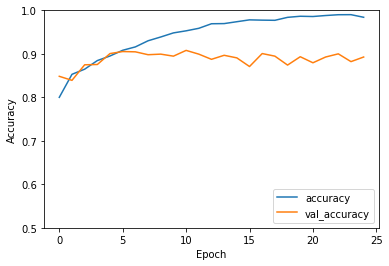

In [0]:
plot_history(history2)

pred = model2.predict(test_X)
pred_1 = np.argmax(pred, axis=1)

conf_matrix = confusion_matrix(test_y, pred_1, labels=[0, 1, 2])
print("Confusion matrix:")
print(conf_matrix)
print(classification_report(test_y, pred_1, digits=3))

# **Model 3 - Like model 2 but with batch normalization**
1. Model definition

In [0]:
model3 = keras.models.Sequential()
model3.add(layers.Conv2D(64, (3, 3), padding = 'same', activation='relu', input_shape=(224, 224, 1)))
model3.add(layers.MaxPooling2D((4, 4)))
model3.add(layers.BatchNormalization())
model3.add(layers.Conv2D(128, (3, 3), padding = 'same', activation='relu'))
model3.add(layers.MaxPooling2D((4, 4)))
model3.add(layers.BatchNormalization())
model3.add(layers.Conv2D(256, (3, 3), activation='relu'))
model3.add(layers.Flatten())
model3.add(layers.BatchNormalization())
model3.add(layers.Dense(64, activation='relu'))
#model3.add(layers.BatchNormalization())
model3.add(layers.Dense(32, activation='relu'))
#model3.add(layers.BatchNormalization())
model3.add(layers.Dense(3))

model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 256)       295168    
_________________________________________________________________
flatten (Flatten)            (None, 36864)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                2

2. Training

In [0]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

history3 = model3.fit(train_X, train_y, epochs=25, 
                    validation_data=(test_X, test_y))


Epoch 1/25
427/427 [==============================] - 39s 90ms/step - loss: 0.8790 - accuracy: 0.7850 - val_loss: 0.9556 - val_accuracy: 0.4841
Epoch 2/25
427/427 [==============================] - 38s 90ms/step - loss: 0.4135 - accuracy: 0.8453 - val_loss: 0.4072 - val_accuracy: 0.8596
Epoch 3/25
427/427 [==============================] - 38s 90ms/step - loss: 0.3473 - accuracy: 0.8666 - val_loss: 0.5157 - val_accuracy: 0.8444
Epoch 4/25
427/427 [==============================] - 38s 90ms/step - loss: 0.3236 - accuracy: 0.8768 - val_loss: 1.1611 - val_accuracy: 0.4503
Epoch 5/25
427/427 [==============================] - 38s 89ms/step - loss: 0.3030 - accuracy: 0.8862 - val_loss: 0.6139 - val_accuracy: 0.7689
Epoch 6/25
427/427 [==============================] - 38s 89ms/step - loss: 0.2795 - accuracy: 0.8927 - val_loss: 1.6456 - val_accuracy: 0.4517
Epoch 7/25
427/427 [==============================] - 38s 89ms/step - loss: 0.2654 - accuracy: 0.8979 - val_loss: 0.7952 - val_accuracy:

3. Performance

Confusion matrix:
[[777 105   3]
 [ 82 512   0]
 [  5  17   9]]
              precision    recall  f1-score   support

           0      0.899     0.878     0.889       885
           1      0.808     0.862     0.834       594
           2      0.750     0.290     0.419        31

    accuracy                          0.860      1510
   macro avg      0.819     0.677     0.714      1510
weighted avg      0.860     0.860     0.857      1510



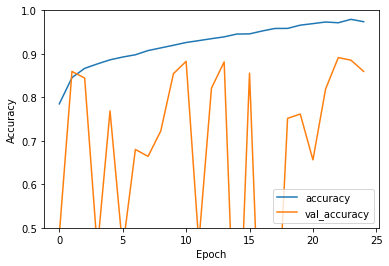

In [0]:
plot_history(history3)

pred = model3.predict(test_X)
pred_1 = np.argmax(pred, axis=1)

conf_matrix = confusion_matrix(test_y, pred_1, labels=[0, 1, 2])
print("Confusion matrix:")
print(conf_matrix)
print(classification_report(test_y, pred_1, digits=3))

# **Alternative Layer Structures**

In [0]:
def residual_block(x, squeeze=16, expand=64):
  m = layers.Conv2D(squeeze, (1,1), activation='relu')(x)
  m = layers.Conv2D(squeeze, (3,3), activation='relu')(m)
  m = layers.Conv2D(expand, (1,1), activation='relu')(m)
  return Add()([m, x])

def inverted_residual_block(x, expand=64, squeeze=16):
  m = layers.Conv2D(expand, (1,1), activation='relu')(x)
  m = layers.DepthwiseConv2D((3,3), activation='relu')(m)
  m = layers.Conv2D(squeeze, (1,1), activation='relu')(m)
  return Add()([m, x])

def inverted_linear_residual_block(x, expand=64, squeeze=16):
  m = layers.Conv2D(expand, (1,1), activation='relu')(x)
  m = layers.DepthwiseConv2D((3,3),  activation='relu')(m)
  m = layers.Conv2D(squeeze, (1,1))(m)
  return Add()([m, x])

def relu6(x):
  return min(max(0, x), 6)

def bottleneck_block(x, expand=64, squeeze=16):
  m = layers.Conv2D(expand, (1,1))(x)
  m = layers.BatchNormalization()(m)
  m = layers.Activation('relu6')(m)
  m = layers.DepthwiseConv2D((3,3))(m)
  m = layers.BatchNormalization()(m)
  m = layers.Activation('relu6')(m)
  m = layers.Conv2D(squeeze, (1,1))(m)
  m = layers.BatchNormalization()(m)
  return Add()([m, x])

def se_block(x, filters, squeeze_ratio=0.25):
    x_ = layers.GlobalAveragePooling2D()(x)
    x_ = layers.Reshape((1,1,filters))(x_)
    squeezed_filters = max(1, int(filters * squeeze_ratio))
    x_ = layers.Conv2D(squeezed_filters , activation='relu')(x_)
    x_ = layers.Conv2D(filters, activation='sigmoid')(x_)
    return multiply()([x, x_])

argument_block = [ 
BlockArgs(kernel_size=3, num_repeat=1, input_filters=32, output_filters=16, expand_ratio=1, id_skip=True, strides=[1, 1], se_ratio=0.25),
BlockArgs(kernel_size=3, num_repeat=2, input_filters=16, output_filters=24, expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
BlockArgs(kernel_size=5, num_repeat=2, input_filters=24, output_filters=40, expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
BlockArgs(kernel_size=3, num_repeat=3, input_filters=40, output_filters=80, expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
BlockArgs(kernel_size=5, num_repeat=3, input_filters=80, output_filters=112, expand_ratio=6, id_skip=True, strides=[1, 1], se_ratio=0.25),
BlockArgs(kernel_size=5, num_repeat=4, input_filters=112, output_filters=192, expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
BlockArgs(kernel_size=3, num_repeat=1, input_filters=192, output_filters=320, expand_ratio=6, id_skip=True, strides=[1, 1], se_ratio=0.25)
]

def mbConv_block(input_data, block_arg):
    “““Mobile Inverted Residual block along with Squeeze 
    and Excitation block.”””
    kernel_size = block_arg.kernel_size
    num_repeat= block_arg.num_repeat
    input_filters= block_arg.input_filters
    output_filters= output_filters.kernel_size
    expand_ratio= block_arg.expand_ratio
    id_skip= block_arg.id_skip
    strides= block_arg.strides
    se_ratio= block_arg.se_ratio

    # expansion phase
    expanded_filters = input_filters * expand_ratio
    x = Conv2D(expanded_filters, 1, padding=’same’, use_bias=False)(input_data)
    x = BatchNormalization()(x)
    x = Activation(swish_activation)(x)

    # depthwise conv
    x = DepthwiseConv2D(kernel_size, strides, padding=’same’, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation(swish_activation)(x)

    # squeeze and excitation phase
    se = GlobalAveragePooling2D()(x) 
    se = Reshape((1, 1, expanded_filters ))(x)
    squeezed_filters = max (1, int(input_filters * se_ratio))
    se = Conv2D(squeezed_filters , 1, activation=swish_activation, padding=’same’)(se)
    se = Conv2D(expanded_filters, 1, activation=’sigmoid’, padding=’same’)(se)
    x = multiply([x, se])

    # output phase
    x = Conv2D(output_filters, 1, padding=’same’, use_bias=False)
    x = BatchNormalization()(x)
    return x



In [0]:
class MyResBlock(tf.keras.Model):
  def __init__(self, squeeze=16, expand=64):
    super(MyResBlock, self).__init__(name='')

    self.squeeze = squeeze
    self.expand = expand
  
  def call(self, x, training=False):
    m = layers.Conv2D(self.squeeze, (1,1), activation='relu')(x)
    m = layers.Conv2D(self.squeeze, (3,3), activation='relu')(m)
    m = layers.Conv2D(self.expand, (1,1), activation='relu')(m)

    return Add()([m, x])

class MyInvResBlock(tf.keras.Model):
  def __init__(self, expand=64, squeeze=16):
    super(MyInvResBlock, self).__init__(name='')
    self.expand = expand
    self.squeenze = squeeze

  def call(self, x, training=False):
    m = layers.Conv2D(self.expand, (1,1), activation='relu')(x)
    m = layers.DepthwiseConv2D((3,3), activation='relu')(m)
    m = layers.Conv2D(self.squeeze, (1,1), activation='relu')(m)
    return Add()([m, x])

class MyInvLinResBlock(tf.keras.Model):
  def __init__(self, expand=64, squeeze=16):
    super(MyInvLinResBlock, self).__init__(name='')
    self.expand = expand
    self.squeeze = squeeze

  def call(self, x, training=False):
    m = layers.Conv2D(self.expand, (1,1), activation='relu')(x)
    m = layers.DepthwiseConv2D((3,3),  activation='relu')(m)
    m = layers.Conv2D(self.squeeze, (1,1))(m)
    return Add()([m, x])
  

class MyInvLinResBlock(tf.keras.Model):
  def __init__(self, expand=64, squeeze=16):
    super(MyInvLinResBlock, self).__init__(name='')
    self.expand = expand
    self.squeeze = squeeze

  def call(self, x, training=False):
    m = layers.Conv2D(self.expand, (1,1), activation='relu')(x)
    m = layers.DepthwiseConv2D((3,3),  activation='relu')(m)
    m = layers.Conv2D(self.squeeze, (1,1))(m)
    return Add()([m, x])
  

class BottleneckBlock(tf.keras.Model)
  def __init__(self, expand=64, squeeze=16):
    super(MyInvLinResBlock, self).__init__(name='')
    self.expand = expand
    self.squeeze = squeeze

  def call(self, x, training=False):
    m = layers.Conv2D(self.expand, (1,1))(x)
    m = layers.BatchNormalization()(m)
    m = layers.Activation(tf.nn.relu6)
    m = layers.DepthwiseConv2D((3,3))(m)
    m = layers.BatchNormalization()(m)
    m = layers.Activation(tf.nn.relu6)
    m = layers.Conv2D(self.squeeze, (1,1))(m)
    m = layers.BatchNormalization()(m)
    return Add()([m, x])
 

# **EfficientNet Baseline model**

In [0]:
efficientNet = keras.models.Sequential()
efficientNet.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(224, 224, 1)))
efficientNet.add(mbConv_block())


# **Testing Alternative Layer Structures**